<a href="https://colab.research.google.com/github/ofussr/NeuralNetworks/blob/main/task2_308_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ucimlrepo

### Импорт необходимых библиотек

In [3]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from sklearn.preprocessing       import StandardScaler, LabelEncoder
from sklearn.metrics             import mean_squared_error, r2_score
from ucimlrepo                   import fetch_ucirepo
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Dense, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import Adam


### Загрузка и подготовка данных

In [4]:
steel_industry_energy_consumption = fetch_ucirepo(id=851)
X = steel_industry_energy_consumption.data.features
y = steel_industry_energy_consumption.data.targets

data = pd.concat([X, y], axis=1)

label_encoder = LabelEncoder()
data['WeekStatus']  = label_encoder.fit_transform(data['WeekStatus'])
data['Day_of_week'] = label_encoder.fit_transform(data['Day_of_week'])
data['Load_Type']   = label_encoder.fit_transform(data['Load_Type'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data  = scaled_data[train_size:]


### Создание последовательностей для временных рядов

In [5]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test   = create_sequences(test_data, seq_length)

### Создание RNN

In [6]:
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

rnn_model = build_rnn_model((seq_length, X_train.shape[2]))
rnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                3050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 3101 (12.11 KB)
Trainable params: 3101 (12.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Создание GRU

In [7]:
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

gru_model = build_gru_model((seq_length, X_train.shape[2]))
gru_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                9300      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 9351 (36.53 KB)
Trainable params: 9351 (36.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Создание LSTM

In [8]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

lstm_model = build_lstm_model((seq_length, X_train.shape[2]))
lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [9]:
epochs     = 25
batch_size = 64

rnn_history  = rnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
gru_history  = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
lstm_history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/25
351/351 [==============================] - 3s 6ms/step - loss: 0.2111 - val_loss: 0.1136
Epoch 2/25
351/351 [==============================] - 2s 7ms/step - loss: 0.1502 - val_loss: 0.1063
Epoch 3/25
351/351 [==============================] - 3s 8ms/step - loss: 0.1386 - val_loss: 0.1027
Epoch 4/25
351/351 [==============================] - 2s 6ms/step - loss: 0.1320 - val_loss: 0.0977
Epoch 5/25
351/351 [==============================] - 2s 5ms/step - loss: 0.1259 - val_loss: 0.0939
Epoch 6/25
351/351 [==============================] - 2s 7ms/step - loss: 0.1202 - val_loss: 0.0953
Epoch 7/25
351/351 [==============================] - 3s 8ms/step - loss: 0.1172 - val_loss: 0.0891
Epoch 8/25
351/351 [==============================] - 2s 6ms/step - loss: 0.1136 - val_loss: 0.0904
Epoch 9/25
351/351 [==============================] - 3s 8ms/step - loss: 0.1113 - val_loss: 0.0865
Epoch 10/25
351/351 [==============================] - 2s 5ms/step - loss: 0.1091 - val_loss: 0.0821

### Оценка

In [10]:
y_pred_rnn  = rnn_model.predict(X_test)
y_pred_gru  = gru_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)

def calculate_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    return mse, rmse, r2

mse_rnn, rmse_rnn, r2_rnn    = calculate_metrics(y_test, y_pred_rnn)
mse_gru, rmse_gru, r2_gru    = calculate_metrics(y_test, y_pred_gru)
mse_lstm, rmse_lstm, r2_lstm = calculate_metrics(y_test, y_pred_lstm)

print("RNN - MSE: {:.4f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_rnn, rmse_rnn, r2_rnn))
print("GRU - MSE: {:.4f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_gru, rmse_gru, r2_gru))
print("LSTM - MSE: {:.4f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_lstm, rmse_lstm, r2_lstm))


219/219 [==============================] - 1s 5ms/step
RNN - MSE: 0.0809, RMSE: 0.2845, R²: 0.9081
GRU - MSE: 0.0723, RMSE: 0.2689, R²: 0.9179
LSTM - MSE: 0.0752, RMSE: 0.2742, R²: 0.9146


### Визуализация реальных и предсказанных значений

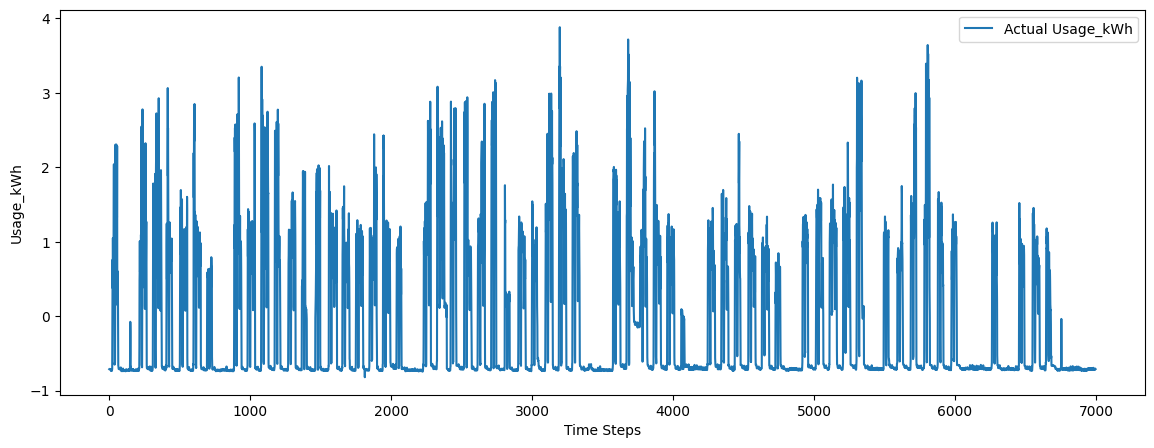

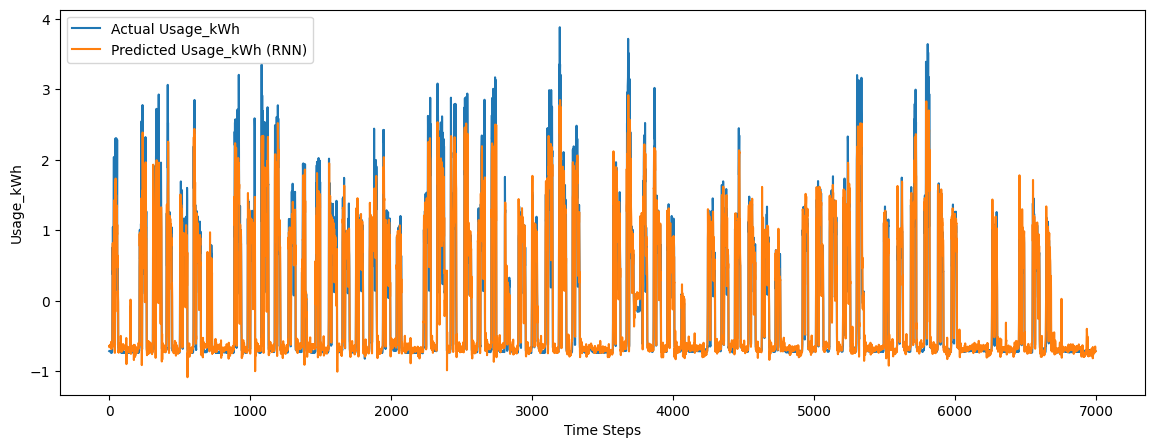

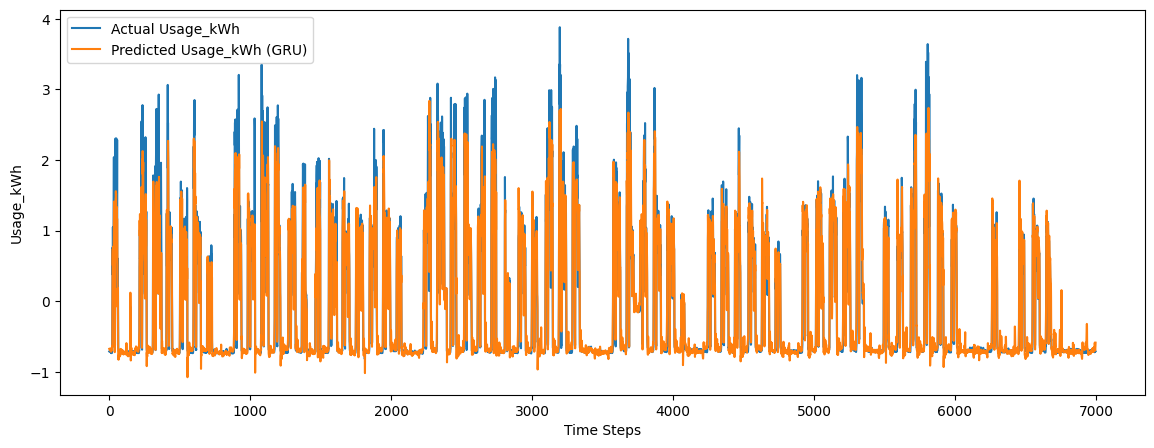

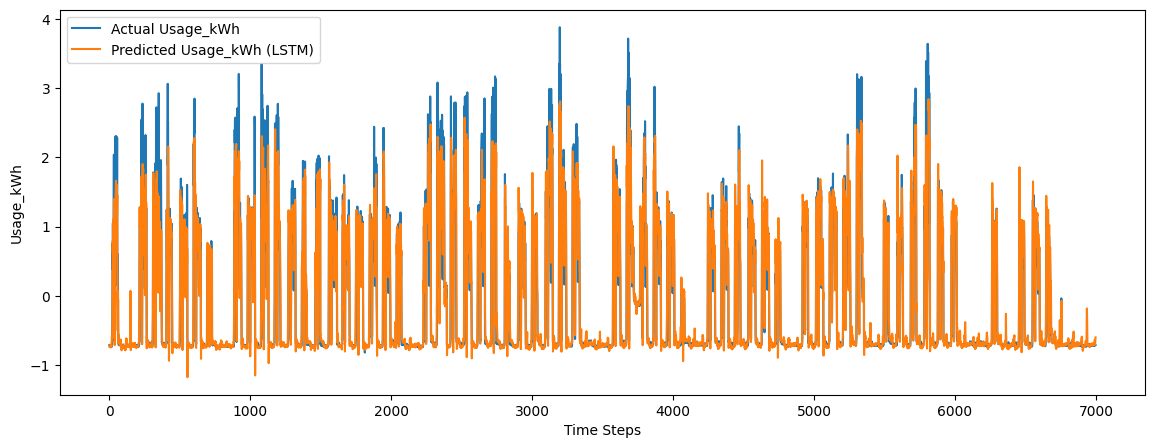

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Usage_kWh')
plt.xlabel('Time Steps')
plt.ylabel('Usage_kWh')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Usage_kWh')
plt.plot(range(len(y_pred_rnn)), y_pred_rnn, label='Predicted Usage_kWh (RNN)')
plt.xlabel('Time Steps')
plt.ylabel('Usage_kWh')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Usage_kWh')
plt.plot(range(len(y_pred_gru)), y_pred_gru, label='Predicted Usage_kWh (GRU)')
plt.xlabel('Time Steps')
plt.ylabel('Usage_kWh')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Usage_kWh')
plt.plot(range(len(y_pred_lstm)), y_pred_lstm, label='Predicted Usage_kWh (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Usage_kWh')
plt.legend()
plt.show()